In [1]:
!python -m pip install --upgrade matrice

In [2]:
import yaml
import os

class Vars:
    _data = {}
    _path = None

    @classmethod
    def initialize(cls, path):
        cls._path = path
        cls._data = cls.load()

    @classmethod
    def load(cls):
        if cls._path and os.path.exists(cls._path):
            with open(cls._path, 'r') as f:
                return yaml.safe_load(f)
        return {}

    @classmethod
    def get(cls, key):
        if key not in cls._data:
            raise KeyError(f"Variable {key} not found")
        return cls._data[key]

    @classmethod
    def set(cls, key, value):
        cls._data[key] = value
        with open(cls._path, 'w') as f:
            yaml.safe_dump(cls._data, f, default_flow_style=False)


In [3]:
Vars.initialize('vars.yaml')

In [ ]:
Vars.set("ENV", "dev")
Vars.set("MATRICE_ACCESS_KEY_ID", "IDAZ************MQO6")
Vars.set("MATRICE_SECRET_ACCESS_KEY", "52VR************ZY5N8")
Vars.set("MATRICE_ACCOUNT_NUMBER", "227684************7135")

In [5]:
import os
os.environ['ENV'] = Vars.get('ENV')
access_key = Vars.get('MATRICE_ACCESS_KEY_ID')
secret_key = Vars.get('MATRICE_SECRET_ACCESS_KEY')
account_number = Vars.get('MATRICE_ACCOUNT_NUMBER')

In [6]:
from matrice.session import Session
from matrice.projects import Projects
from matrice.dataset import Dataset
from matrice.models import Model
from matrice.deployment import Deployment
from matrice.exported_model import ExportedModel
import sys
import os

In [7]:
session_instance = Session.create_session(account_number=account_number, access_key=access_key, secret_key=secret_key)
print("A Session has been initialized:", session_instance)

A Session has been initialized: <matrice.session.Session object at 0x000001912985A6D0>


In [8]:
projects_list, msg = session_instance.list_projects(project_type="detection")

# Check if there is a message or error
if msg:
    print(f"Message: {msg}")

# Print the projects in a formatted manner
for project_name, project_instance in projects_list.items():
    print(f"Project Name: {project_name} | Project ID: {project_instance.project_id}")

Message: Projects fetched successfully
Project Name: Crop-Weed-Detection | Project ID: 6728bd804e370c5e10793517
Project Name: Drone-Windmill-Maintainence | Project ID: 672251b73f122d1d31ac85df
Project Name: Test-Project-1 | Project ID: 67221278e444a8664263f806
Project Name: test-det | Project ID: 671f7af124f52600d8b27df2
Project Name: Drone Detection Use Case 1 | Project ID: 66c6fa777668fd51f7b98c74
Project Name: Crop Detection Use Case Final-4 | Project ID: 66c5cffd2dca8efe8f2562ec
Project Name: instance_segmentation | Project ID: 66a08a0ea6b455cdb12a5d59
Project Name: Demo1 | Project ID: 668b2bac4f0265d79523f23d
Project Name: kaggle_demo | Project ID: 66416ab972f6cd7a92435408


In [9]:
project_name = "Shoplifting-Retail-Detection"
for name, project_instance in projects_list.items():
    if name == project_name:
        projects_instance = Projects(session_instance, project_name=project_name)
        session_instance.update(projects_instance.project_id)
        print(f"Project '{project_name}' already exists. Initialized Projects instance.")
        project_exists = True
        break
    else:
        project_exists = False

if project_exists == False:
    print(f"Creating a new project: {project_name}")

Creating a new project: Shoplifting-Retail-Detection


In [10]:
import pprint

name = "Shoplifting-Retail-Detection"

# Function to create a project
def create_project():
    project_name = name
    input_type = "image"
    output_type = "detection"
    
    enabled_platforms = {
        "matrice": True,
        "android": False,
        "ios": False,
        "tpu": False,
        "intelCPU": False,
        "gcloudGPU": False
    }

    resp, error = session_instance._create_project(project_name, input_type, output_type)
    if error:
        print(f"Error: {error}")
        return None, None
    else:
        print(f"Project created with ID: {resp['_id']}")
        return resp['_id'], resp['name']

# Check if project_id and project_name exist
project_id = None
project_name = None

if not project_exists:
    project_id, project_name = create_project()
else:
    project_id = projects_instance.project_id
    project_name = projects_instance.project_name
    print(f"Project already exists with ID: {project_id} and Name: {project_name}")


print("----------------------------")
print(f"Project ID: {project_id}")
print(f"Project Name: {project_name}")
print("----------------------------")


Project created with ID: 6728cc001478c8033c87753b
----------------------------
Project ID: 6728cc001478c8033c87753b
Project Name: Shoplifting-Retail-Detection
----------------------------


In [11]:
Vars.set("project_name",project_name)
Vars.set("project_id", project_id)

In [12]:
session_instance.update(project_id)
project_instance = Projects(session_instance, project_name=project_name)
print("A Project class has been initialized",project_instance)

A Project class has been initialized <matrice.projects.Projects object at 0x000001912A06FD10>


In [ ]:
import os
import json
import cv2
import shutil
from tqdm import tqdm

def convert_yolo_to_coco(dataset_dir, output_dir, class_names):
    # Prepare directories for the COCO dataset structure
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'annotations'), exist_ok=True)
    
    # Define dataset parts
    parts = ['train', 'test', 'val']
    
    annotation_id = 1
    
    # Iterate over each part (train, test, val)
    for part in parts:
        yolo_images_dir = os.path.join(dataset_dir, part, 'images')
        yolo_labels_dir = os.path.join(dataset_dir, part, 'labels')
        coco_json = {
            "images": [],
            "annotations": [],
            "categories": []
        }
        
        class_ids = set()

        # Process images and annotations
        for filename in tqdm(os.listdir(yolo_labels_dir)):
            if filename.endswith(".txt"):
                image_id = filename[:-4]  # Remove the '.txt' extension to get the full image_id
                
                # Construct the image path using the full image_id
                image_path = os.path.join(yolo_images_dir, f"{image_id}.jpg")
                try:
                    # Check if the corresponding image exists
                    if not os.path.exists(image_path):
                        print(f"Warning: Image file {image_path} not found, skipping.")
                        continue
                    
                    # Open the image to get its dimensions
                    img = cv2.imread(image_path)
                    height, width, _ = img.shape
                    
                    # Copy image to COCO images directory
                    shutil.copy(image_path, os.path.join(output_dir, f'images/{part}/{image_id}.jpg'))
                    
                    # Add image information to COCO format
                    coco_json["images"].append({
                        "id": image_id,
                        "file_name": f"{image_id}.jpg",
                        "width": width,
                        "height": height
                    })
                    
                    # Read YOLO annotations
                    with open(os.path.join(yolo_labels_dir, filename), 'r') as f:
                        for line in f.readlines():
                            class_id, x_center, y_center, box_width, box_height = map(float, line.split())
                            
                            # Convert YOLO format to COCO format
                            x_min = int((x_center - box_width / 2) * width)
                            y_min = int((y_center - box_height / 2) * height)
                            box_width = int(box_width * width)
                            box_height = int(box_height * height)
                            
                            # Adjust class_id to start from 1 instead of 0
                            coco_class_id = int(class_id) + 1
                            
                            # Add annotation to COCO format
                            coco_json["annotations"].append({
                                "id": annotation_id,
                                "image_id": image_id,
                                "category_id": coco_class_id,
                                "bbox": [x_min, y_min, box_width, box_height],
                                "area": box_width * box_height,
                                "iscrowd": 0
                            })
                            
                            annotation_id += 1
                            class_ids.add(coco_class_id)
                            
                except FileNotFoundError as e:
                    print(f"Warning: {e}. Skipping this file and moving on to the next.")
                    continue
                
                except Exception as e:
                    print(f"Warning: An unexpected error occurred: {e}. Skipping this file and moving on to the next.")
                    continue
                
        # Add categories to COCO format
        for class_id in sorted(class_ids):
            coco_json["categories"].append({
                "id": class_id,
                "name": class_names[class_id - 1],  # class_names is a list of class names indexed from 0
                "supercategory": "object"
            })
        
        # Save the COCO formatted annotations to a JSON file
        output_json = os.path.join(output_dir, f'annotations/{part}.json')
        with open(output_json, 'w') as f:
            json.dump(coco_json, f, indent=4)
        
        print(f"Conversion completed for {part}! COCO format saved to {output_json}")




In [13]:
dataset_dir = r"C:\Users\pathi\OneDrive\Desktop\matriceai\matrice_usecases_local\datasets\Shoplift"
output_dir = r"C:\Users\pathi\OneDrive\Desktop\matriceai\matrice_usecases_local\datasets\shoplift_mscoco"
class_names = ['EmptyHands', 'droping', 'picking-hold', 'shoplifting']


In [ ]:
import os

def convert_yolo_to_coco_safe(dataset_dir, output_dir, class_names):
    try:
        convert_yolo_to_coco(dataset_dir, output_dir, class_names)
    except FileNotFoundError as e:
        print(f"Warning: {e}. Skipping this file and moving on to the next.")
        
    
convert_yolo_to_coco_safe(dataset_dir, output_dir, class_names)

<Figure size 1000x1000 with 0 Axes>

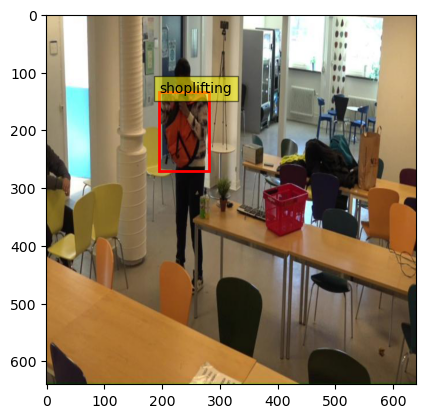

<Figure size 1000x1000 with 0 Axes>

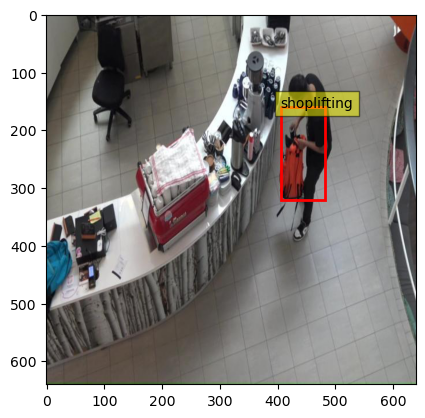

<Figure size 1000x1000 with 0 Axes>

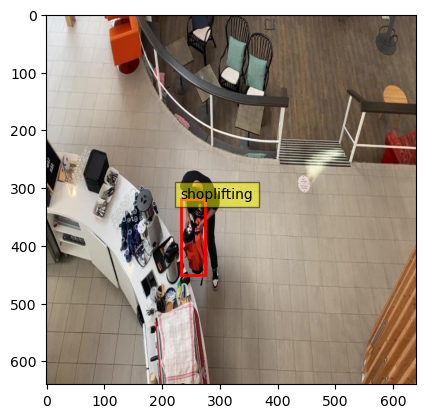

<Figure size 1000x1000 with 0 Axes>

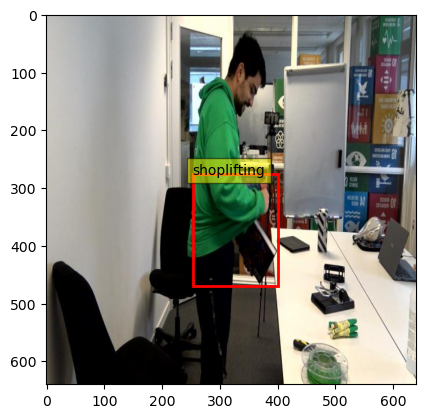

<Figure size 1000x1000 with 0 Axes>

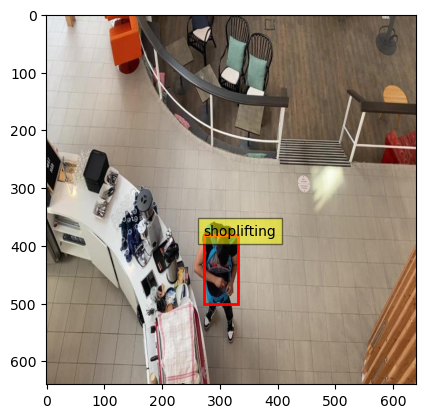

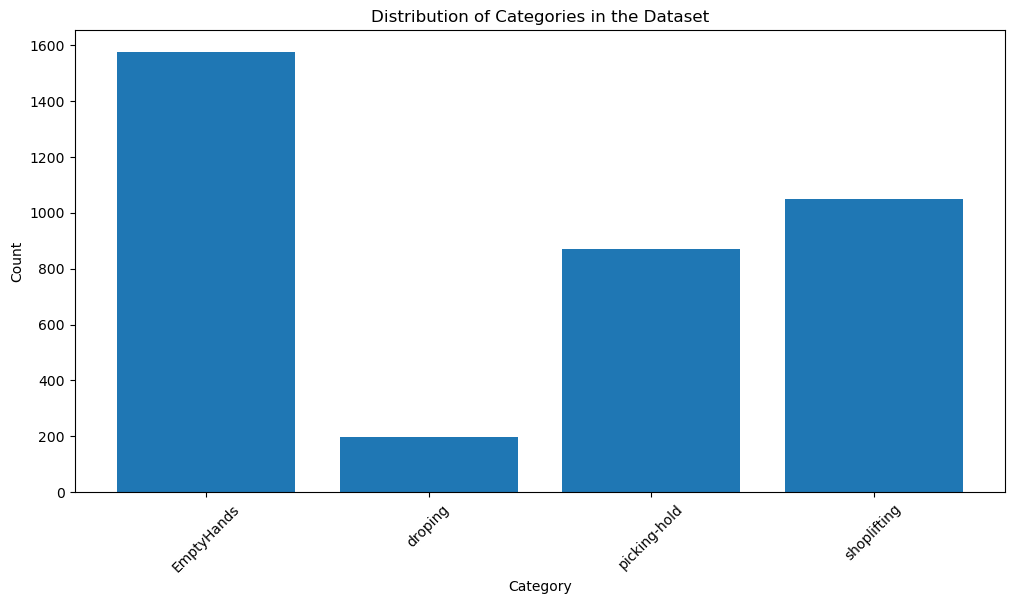

Number of images: 2366
Number of annotations: 3695
Number of categories: 4


In [14]:
import random
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL

# Load the COCO annotations
with open(os.path.join(output_dir, 'annotations/train.json')) as f:
    coco_data = json.load(f)

# Create a dictionary to map image IDs to image file names
image_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}

# Create a dictionary to map category IDs to category names
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Randomly select 5 images
sample_images = random.sample(coco_data['images'], 5)

# Plot the images with bounding boxes
for img in sample_images:
    img_id = img['id']
    img_file = os.path.join(output_dir, 'images/train', img['file_name'])
    
    # Open the image
    image = PIL.Image.open(img_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Plot the bounding boxes
    for ann in coco_data['annotations']:
        if ann['image_id'] == img_id:
            bbox = ann['bbox']
            category_id = ann['category_id']
            category_name = category_id_to_name[category_id]
            
            # Create a Rectangle patch
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1], category_name, bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()

# Perform some EDA
# Count the number of annotations per category
category_counts = {cat['name']: 0 for cat in coco_data['categories']}
for ann in coco_data['annotations']:
    category_name = category_id_to_name[ann['category_id']]
    category_counts[category_name] += 1

# Plot the category distribution
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories in the Dataset')
plt.xticks(rotation=45)
plt.show()

# Print some basic statistics
num_images = len(coco_data['images'])
num_annotations = len(coco_data['annotations'])
num_categories = len(coco_data['categories'])

print(f"Number of images: {num_images}")
print(f"Number of annotations: {num_annotations}")
print(f"Number of categories: {num_categories}")

In [ ]:
import shutil

# Define the name of the zip file
zip_file_name = output_dir + '.zip'

# Create a zip file
shutil.make_archive(output_dir, 'zip', output_dir)

print(f"Output directory {output_dir} has been zipped into {zip_file_name}")

In [15]:
dataset, dataset_action = project_instance.import_local_dataset(
    dataset_name='Shoplift-Detection-Dataset',
    file_path = r"C:\Users\pathi\OneDrive\Desktop\matriceai\matrice_usecases_local\datasets\shoplift_mscoco.zip",
    dataset_type = "detection",
    dataset_description = "Dataset of shoplifting detection",
    version_description = "1st version",
    input_type = "image"
)

In [16]:
dataset_id = dataset.dataset_id
action_id = dataset_action.action_id

print(f"Dataset ID: {dataset_id}")
print(f"Action ID: {action_id}")

Dataset ID: 6728ccc30623cf13c1a4574c
Action ID: 6728ccc31478c8033c87753e


In [17]:
Vars.set("dataset_id", dataset.dataset_id)
Vars.set("dataset_action_id", dataset_action.action_id)

In [18]:
import time
import pprint

action_id = dataset_action.action_id
def check_dataset_status():
    while True:
        print(" ")
        print("-------Status------")
        D = Dataset(session_instance, dataset_id=dataset_id)
        status = D.version_status
        print("Status of dataset:", status)
        print("-------------------")
        if status == 'processed':
            print("---------Preprocesing Complete---------")
            print("Dataset processed, proceed with experiment creation.")
            print("---------------------------------------")
            break
        
        time.sleep(90)  # Wait for 90 seconds before checking again

# Run the function to check dataset status
check_dataset_status()


 
-------Status------
Status of dataset: processing
-------------------
 
-------Status------
Status of dataset: processing
-------------------
 
-------Status------
Status of dataset: processed
-------------------
---------Preprocesing Complete---------
Dataset processed, proceed with experiment creation.
---------------------------------------


In [19]:
def print_dataset_info(dataset):
   
    dataset_id = dataset.dataset_details['_id']
    dataset_name = dataset.dataset_details['name']
    version_status = dataset.dataset_details.get("stats", [{}])[0].get("versionStatus")
    latest_version = dataset.dataset_details['latestVersion']
    no_of_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
    no_of_classes = len(dataset.dataset_details.get('stats', [{}])[0].get('classStat', {}))
    no_of_versions = len(dataset.dataset_details.get('allVersions', []))
    last_updated_at = dataset.dataset_details.get('updatedAt')

    print(f"Dataset ID: {dataset_id}")
    print(f"Dataset Name: {dataset_name}")
    print(f"Version Status: {version_status}")
    print(f"Latest Version: {latest_version}")
    print(f"Number of Samples: {no_of_samples}")
    print(f"Number of Classes: {no_of_classes}")
    print(f"Number of Versions: {no_of_versions}")
    print(f"Last Updated At: {last_updated_at}")

dataset.refresh()   
print_dataset_info(dataset)

Dataset ID: 6728ccc30623cf13c1a4574c
Dataset Name: Shoplift-Detection-Dataset
Version Status: processed
Latest Version: v1.0
Number of Samples: 3168
Number of Classes: 4
Number of Versions: 1
Last Updated At: 2024-11-04T13:35:47.866Z


In [20]:
dataset_summary = dataset.summary

In [21]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio


# Convert the histogram data to a DataFrame
df = pd.DataFrame(dataset_summary['histogram'])

# Bar chart for counts by category
fig1 = go.Figure(data=[go.Bar(x=df['label'], y=df['count'])])
fig1.update_layout(
    title='Count of Items by Category',
    xaxis_title='Category',
    yaxis_title='Count'
)

# Pie chart for distribution of data items
fig2 = go.Figure(data=[go.Pie(
    labels=['Test', 'Train', 'Unassigned', 'Validation'],
    values=[dataset_summary['testDataItemCount'], dataset_summary['trainDataItemCount'], dataset_summary['unassignedDataItemCount'], dataset_summary['valDataItemCount']],
    hole=0.3
)])
fig2.update_layout(
    title='Distribution of Data Items'
)

# Display the figures
fig1.show()
fig2.show()


In [ ]:
import os
import json
import pprint
import uuid

# Generate a unique experiment name
unique_experiment_name = "Shoplifting-Detection-Experiment"

# Function to create an experiment
def create_experiment():
    name = unique_experiment_name
    target_run_time = ["PyTorch"]
    primary_metric = "mAP50"
    matrice_compute = True
    dataset_version = 'v1.0'

    experiment_instance = project_instance.create_experiment(
        name,
        dataset_id,
        target_run_time[0],
        dataset_version,
        primary_metric,
        matrice_compute
    )

    print(experiment_instance)
    experiment_id = experiment_instance.experiment_id
    experiment_name = experiment_instance.experiment_name

    print(f"Experiment ID: {experiment_id}")
    print(f"Experiment Name: {experiment_name}")

    return experiment_instance, experiment_id, experiment_name

# Create a new experiment
experiment_instance , experiment_id, experiment_name = create_experiment()

print("----------------------------")
print(f"Experiment ID: {experiment_id}")
print(f"Experiment Name: {experiment_name}")
print(f"Experiment instance has been created: {experiment_instance}")
print("----------------------------")

[{'_id': '6728ccc30623cf13c1a4574c', 'name': 'Shoplift-Detection-Dataset', '_idProject': '6728cc001478c8033c87753b', 'status': '', 'createdAt': '2024-11-04T13:31:47.624Z', 'updatedAt': '2024-11-04T13:35:47.866Z', 'stats': [{'version': 'v1.0', 'versionStats': {'test': 244, 'train': 2366, 'val': 558, 'unassigned': 0, 'total': 3168}, 'versionDescription': '1st version', 'classStat': {'EmptyHands': {'total': 2141, 'train': 1575, 'test': 180, 'val': 386, 'unassigned': 0}, 'droping': {'total': 264, 'train': 198, 'test': 22, 'val': 44, 'unassigned': 0}, 'picking-hold': {'total': 1131, 'train': 871, 'test': 87, 'val': 173, 'unassigned': 0}, 'shoplifting': {'total': 1420, 'train': 1051, 'test': 106, 'val': 263, 'unassigned': 0}}, 'versionStatus': 'processed', 'isFrozen': False, 'splitwiseBalance': True, 'classwiseBalance': False}], 'allVersions': ['v1.0'], 'processedVersions': ['v1.0'], 'latestVersion': 'v1.0', 'disabledVersions': None}]
Experiment ID: 6728ceae732d9d4b27f8c392
Experiment Name: 

In [23]:
Vars.set("experiment_id", experiment_instance.experiment_id)
Vars.set("experiment_name", experiment_instance.experiment_name)

In [24]:
from matrice.model_store import _get_all_model_families 

resp , error , mesage = _get_all_model_families( session_instance , project_id , project_type="detection" )
print("----List of available Detection models on platform----")
# Iterate through each model family in the response
for model_family in resp:
    # Extract _id and modelFamily (model family name)
    model_family_id = model_family.get('_id')
    name = model_family.get('modelFamily')
    
    # Print in formatted manner
    print(f"ID: {model_family_id}, Model Family Name: {name}")

----List of available Detection models on platform----
ID: 66952a599bbb09931616d49d, Model Family Name: Faster R-CNN
ID: 66952a7e9bbb09931616d4ae, Model Family Name: FCOS
ID: 66952afb9bbb09931616d4d4, Model Family Name: Owl_VIT
ID: 66952b139bbb09931616d4db, Model Family Name: YoloV8
ID: 66952b8a9bbb09931616d537, Model Family Name: RetinaNet
ID: 66952c089bbb09931616d571, Model Family Name: SSD
ID: 66a208cab48d0add30eee95e, Model Family Name: YoloV9
ID: 66a5f11a4c150a49a2b8d308, Model Family Name: YoloV10
ID: 66e989a32e0a4c439a1d02d5, Model Family Name: vyguvgyhv


In [27]:
from matrice.model_store import ModelFamily

model_family_id = "66952b139bbb09931616d4db"
# Initialize the ModelFamily instance after choosing a Model Family
model_family_instance = ModelFamily(session_instance, model_family_id=model_family_id) # YOLOV8
print("A ModelFamily instance has been initialized",model_family_instance)

A ModelFamily instance has been initialized <matrice.model_store.ModelFamily object at 0x000001912A095C50>


In [28]:
# Fetch model architectures
import pprint
arch_resp, error, message = model_family_instance.get_model_archs()
if error:
    print(f"Error: {error}")
else:
    pprint.pprint(arch_resp)
    # Check if resp is a list or a dictionary
    if isinstance(arch_resp, list):
        # Iterate through each model info in the list
        for model_info in arch_resp:
            model_key = model_info["model_key"]
            model_arch_instance = model_info["model_arch_instance"]
            
            # Extract model information
            model_info_id = model_arch_instance.model_info_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} |  Model Name: {name} | Model Key: {key} | Params in Millions: {params}")
            
    elif isinstance(arch_resp, dict):
        # Iterate through each model key in the dictionary
        for model_key, model_arch_instance in arch_resp.items():
            # Extract model information
            model_info_id = model_arch_instance.model_info_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} | Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

{'yolov8l': <matrice.model_store.ModelArch object at 0x000001912DB47090>,
 'yolov8m': <matrice.model_store.ModelArch object at 0x000001912D9F5910>,
 'yolov8n': <matrice.model_store.ModelArch object at 0x000001912D8E8210>,
 'yolov8s': <matrice.model_store.ModelArch object at 0x000001912A346CD0>,
 'yolov8x': <matrice.model_store.ModelArch object at 0x000001912A22F490>}
ID: 66952b179bbb09931616d4dc | Model Name: YOLOv8 Large | Model Key: yolov8l | Params in Millions: 43.7
ID: 66952b1b9bbb09931616d4dd | Model Name: YOLOv8 Medium | Model Key: yolov8m | Params in Millions: 25.9
ID: 66952b209bbb09931616d4de | Model Name: YOLOv8 Nano | Model Key: yolov8n | Params in Millions: 3.2
ID: 66952b249bbb09931616d4df | Model Name: YOLOv8 Small | Model Key: yolov8s | Params in Millions: 11.2
ID: 66952b289bbb09931616d4e0 | Model Name: YOLOv8 Xtra Large | Model Key: yolov8x | Params in Millions: 68.2


In [29]:
from matrice.model_store import ModelArch
train_arch = 'yolov8n' 
print("Chosen Training Architecture :" ,train_arch)
model_arch_instance = arch_resp.get(train_arch)
print("Model Architecture instance initialized for chosen training architecture :", model_arch_instance)

Chosen Training Architecture : yolov8n
Model Architecture instance initialized for chosen training architecture : <matrice.model_store.ModelArch object at 0x000001912D8E8210>


In [30]:
import pprint
train_instance , train_config = model_arch_instance.get_train_config(experiment_id=Vars.get('experiment_id'))
print("-----Default Train Config------")
pprint.pprint(train_config)
print("--------------------------------")
print("-------Training instance initialized--------")
print(train_instance)

-----Default Train Config------
{'action_config': {'batch': {'allowedValues': [1,
                                               2,
                                               4,
                                               8,
                                               16,
                                               32,
                                               64,
                                               128,
                                               256,
                                               512],
                             'anyValue': True,
                             'defaultValue': 16,
                             'hyperparameter': True,
                             'keyName': 'batch',
                             'maxValue': 1024,
                             'minValue': 1,
                             'selectedValues': [16],
                             'valueType': 'int32'},
                   'cos_lr': {'allowedValues': [False, True],
  

In [31]:
model_config = train_config['model_config']

# Modify the model_config as needed
# modifications:
model_config['batch'] = [8]
model_config['epochs'] = [60]



# Repass the modified model_config into the train_config
train_config['model_config'] = model_config

# Print the updated train_config
print("-----Updated Model Config------")
pprint.pprint(train_config['model_config'])
print("--------------------------------")

# Print the updated train_config
print("-----Updated Train Config------")
pprint.pprint(train_config)
print("--------------------------------")

-----Updated Model Config------
{'batch': [8],
 'cos_lr': [False],
 'epochs': [60],
 'learning_rate': [0.001],
 'momentum': [0.95],
 'optimizer': ['auto'],
 'weight_decay': [0.0005]}
--------------------------------
-----Updated Train Config------
{'action_config': {'batch': {'allowedValues': [1,
                                               2,
                                               4,
                                               8,
                                               16,
                                               32,
                                               64,
                                               128,
                                               256,
                                               512],
                             'anyValue': True,
                             'defaultValue': 16,
                             'hyperparameter': True,
                             'keyName': 'batch',
                             'maxValue': 102

In [32]:
train_resp , msg , err = experiment_instance.add_models_for_training(train_instance,train_config)
print("------------Model added for training----------")
pprint.pprint(train_resp)

------------Model added for training----------
[{'_id': '6728d225388e36b4e54b5acd',
  '_idActionStatus': '6728d2251478c8033c87756e',
  '_idDataset': '6728ccc30623cf13c1a4574c',
  '_idExperiment': '6728ceae732d9d4b27f8c392',
  '_idModelFamily': '000000000000000000000000',
  '_idModelInfo': '66952b209bbb09931616d4de',
  '_idProject': '6728cc001478c8033c87753b',
  '_idUser': '667996abc47fb97dea838b35',
  'actionConfig': {'batch': {'allowedValues': [1,
                                               2,
                                               4,
                                               8,
                                               16,
                                               32,
                                               64,
                                               128,
                                               256,
                                               512],
                             'anyValue': True,
                             'defaultVal

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = train_resp[0]['_idActionStatus']
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    action_instance = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {action_instance.status}")
    print(f"Step Code: {action_instance.step_code}")
    print(f"Action service is : {action_instance.service_name}")
    print("---------------------")
    return action_instance.status

# Loop to check status every 2 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully trained.")
        break
    else:
        print("Model is training. Waiting 10 minutes before checking again.")
        time.sleep(400)  # Wait for 10 minutes (600 seconds)


---------------------
Action ID: 6728c5601478c8033c877525
Current Status: OK
Step Code: MDL_TRN_STRT
Action service is : be-model
---------------------
Model is training. Waiting 10 minutes before checking again.


In [ ]:
model_id = train_resp[0]['_id']
print(f"Model ID from response data: {model_id}")
    

# Initialize the Model class with the model_id
model_instance = Model(session_instance, model_id)
print("A Model instance has been initialized : ", model_instance)

In [ ]:
# Print the test score, validation score, and best epoch
print(f"Test Score: {model_instance.test_score}")
print(f"Validation Score: {model_instance.val_score}")
print(f"Best Epoch: {model_instance.best_epoch}")

In [ ]:
Vars.set("model_train_id", model_instance.model_id)
Vars.set("model_train_name", model_instance.model_train_name)

In [ ]:
model_instance.plot_epochs_losses()

In [ ]:
model_instance.plot_epochs_metrics()

In [ ]:
model_instance.plot_eval_results()

In [ ]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"C:\Users\pathi\OneDrive\Desktop\matriceai\matrice_usecases_local\datasets\test"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 10)


# Loop through the selected images and send the prediction request
for image_file in random_images:
    
    result, error, message = model_instance.get_prediction(image_file)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()


In [ ]:
model_instance.download_model(file_name="model.pt")

In [ ]:
export_config = train_instance.get_default_export_config("ONNX") # Get the default export config for export format user wants (here ONNX)
print("Export Config for ONNX:")
pprint.pprint(export_config)

In [ ]:
exported_instance , action_instance = project_instance.create_model_export(model_id,"ONNX",export_config)

print("Model Export class has been initialized :", exported_instance )   
print("----------------------------")
print(f"Export ID: {exported_instance.model_export_id}")
print(f"Export Name: {exported_instance.model_export_name}")
print(f"Action ID: {action_instance.action_id}")
print(f"Action Status: {action_instance.status}")
print("----------------------------")

In [ ]:
Vars.set("model_export_id", exported_instance.model_export_id)
Vars.set("model_export_name", exported_instance.model_export_name)

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = action_instance.action_id
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    A = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {A.status}")
    print(f"Step Code: {A.step_code}")
    print(f"Action service is : {A.service_name}")
    print("---------------------")
    return A.status

# Loop to check status every 1.5 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully exported.")
        break
    else:
        print("Model is exporting. Waiting 2 minutes before checking again.")
        time.sleep(90)  # Wait for 1.5 minutes (90 seconds)


In [ ]:
exported_instance.download_model(file_name="model.onnx")

In [ ]:
deployment , deployment_action = project_instance.create_deployment(
    model_id = Vars.get('model_export_id'),  # It can also be model_train_id depending on the model you want to deploy
    deployment_name = "deployment_name",
    shutdown_threshold=20
)

In [ ]:
key_resp = deployment.create_auth_key()
auth_key = key_resp['key']

In [ ]:
Vars.set("deployment_id", deployment.deployment_id)
Vars.set("deployment_name", deployment.deployment_name)
Vars.set("auth_key", auth_key)

In [ ]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"<path_to_test_folder>"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 10)


# Loop through the selected images and send the prediction request
for image_file in random_images:
    
    result, error, message = deployment.get_prediction(auth_key,image_file)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()
